In [1]:
# importing the necessary libraries
import numpy as np
import pandas as pd
from datetime import datetime, time, date
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import IsolationForest

In [2]:
# importing the dataset
data = pd.read_csv('bank_transactions.csv')

#create a copy of the dataset as per best practice
df = data.copy()

In [3]:
# displaying the 1st five columns of the dataset
print("First 5 Rows of the Dataset:")
df.head()

First 5 Rows of the Dataset:


,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [4]:
# displaying the last five columns of the dataset
print("Last 5 Rows of the Dataset:")
df.tail()

Last 5 Rows of the Dataset:


,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
1048562,T1048563,C8020229,8/4/90,M,NEW DELHI,7635.19,18/9/16,184824,799.0
1048563,T1048564,C6459278,20/2/92,M,NASHIK,27311.42,18/9/16,183734,460.0
1048564,T1048565,C6412354,18/5/89,M,HYDERABAD,221757.06,18/9/16,183313,770.0
1048565,T1048566,C6420483,30/8/78,M,VISAKHAPATNAM,10117.87,18/9/16,184706,1000.0
1048566,T1048567,C8337524,5/3/84,M,PUNE,75734.42,18/9/16,181222,1166.0


In [5]:
# number of rows and columns in the dataset
print(f"The dataframe contains {df.shape[0]} rows and {df.shape[1]} columns")

The dataframe contains 1048567 rows and 9 columns


In [6]:
# dataset overview
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


Five columns, TransactionID, CustomerID, CustomerDOB, TransactionDate and TransactionTime have inappropriate data type. TransactionID and CustomerID will be converted to int. CustomerDOB, TransactionDate and TransactionTime to datetime. The information here suggests missing data in CustomerDOB, CustGender, CustLocation and CustAccountBalance

In [8]:
# sum of null values in each row of the dataset
df.isnull().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

Confirming that 4 columns have null values

In [10]:
# percentage of missing values for each column
missing_percentage = ((df.isnull().sum() / len(df)) * 100).round(2)
missing_percentage

TransactionID              0.00
CustomerID                 0.00
CustomerDOB                0.32
CustGender                 0.10
CustLocation               0.01
CustAccountBalance         0.23
TransactionDate            0.00
TransactionTime            0.00
TransactionAmount (INR)    0.00
dtype: float64

CustomerDOB, CustGender, CustLocation and CustAccountBalance have null values. Each feature has less than 1% of null values. Schafer (1999) suggested that a missing data rate of up to 5% is negligible, while Bennett (2001) argued that missing data exceeding 10% can introduce bias into statistical analysis. Therefore, records with null values in these features will be dropped, as their impact on the analysis is expected to be insignificant.

In [12]:
# statistical summary about the data set
df.describe()

,CustAccountBalance,TransactionTime,TransactionAmount (INR)
count,1.046198e+06,1.048567e+06,1.048567e+06
mean,1.154035e+05,1.570875e+05,1.574335e+03
std,8.464854e+05,5.126185e+04,6.574743e+03
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.721760e+03,1.240300e+05,1.610000e+02
50%,1.679218e+04,1.642260e+05,4.590300e+02
75%,5.765736e+04,2.000100e+05,1.200000e+03
max,1.150355e+08,2.359590e+05,1.560035e+06


The average account balance is quite high, with a mean of 115,403.5 INR. The standard deviation is large, indicating a wide range of account balances among customers. The minimum balance is 0, suggesting some customers might have empty accounts. The 75th percentile is 57,657.36 INR, suggesting that 25% of customers have balances above this value. The maximum balance is extremely high (115,035,500 INR), suggesting the presence of very wealthy customers or potential outliers

The average transaction amount is 1,574.33 INR. The standard deviation is 6,574.74 INR, indicating a significant variation in transaction amounts.
The minimum amount is 0, which could represent failed or refunded transactions. The 75th percentile is 1,200 INR, suggesting that 25% of transactions involve amounts greater than this value. The maximum transaction amount is very high (1,560,035 INR), which might warrant further investigation to identify potential outliers or unusual transactions.

# 2. Data Cleaning

The data cleaning process will initially be applied across the entire dataset, addressing null values and duplicates if present. Subsequently, the cleaning will be focused on each column individually to ensure a thorough and comprehensive approach

In [16]:
# the first 5 rows of the dataset
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [17]:
# dropping the null values
df = df.dropna()

In [18]:
# confirmimg dropped null values
df.isnull().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

All rows with null values have been dropped

In [20]:
# checking for duplicate
df[df.duplicated()]

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)


In [21]:
# checking for duplicate
df[df.duplicated()].sum()

TransactionID                0
CustomerID                   0
CustomerDOB                  0
CustGender                   0
CustLocation                 0
CustAccountBalance         0.0
TransactionDate              0
TransactionTime              0
TransactionAmount (INR)    0.0
dtype: object

There are no duplicate rows

# Individual Column Cleaning

## 2.1 Transaction ID

In [25]:
# distinct transaction id
df['TransactionID'].unique()

array(['T1', 'T2', 'T3', ..., 'T1048565', 'T1048566', 'T1048567'],
      dtype=object)

The transaction id column is prefixed with a "T" which might seem to be unnecessary. This will be deleted so that the column can be converted to integer

In [27]:
# number of distinct transaction id
df['TransactionID'].nunique()

1041614

In [28]:
# extracting the digits from the transaction id
df["TransactionID"] = df["TransactionID"].str.extract(r'(\d+)').astype(int)

In [29]:
# confirming digit exraction
df['TransactionID'].unique()

array([      1,       2,       3, ..., 1048565, 1048566, 1048567])

## 2.2 Customer ID

In [31]:
# disntinct  customer id
df['CustomerID'].unique()

array(['C5841053', 'C2142763', 'C4417068', ..., 'C8020229', 'C6459278',
       'C6420483'], dtype=object)

In [32]:
# number of unique customer id
df['CustomerID'].nunique()

879358

The customer id is also prefixed with a "C" and there are 879358 unique or distinct customer ids. 

In [34]:
# extracting the digits from the customer id
df["CustomerID"] = df["CustomerID"].str.extract(r'(\d+)').astype(int)

In [35]:
# confirming digit exraction
df['CustomerID'].unique()

array([5841053, 2142763, 4417068, ..., 8020229, 6459278, 6420483])

## 2.3 Customer Date of Birth

The customer date of birth is in object data type and this need to be converted to datetime data type

In [38]:
# Convert the CustomerDOB column to datetime and handling errors
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], errors='coerce')

C:\Users\CHUKS\AppData\Local\Temp\ipykernel_22752\739430568.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], errors='coerce')


In [39]:
# checking the data type for CustomerDOB 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1041614 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   TransactionID            1041614 non-null  int32         
 1   CustomerID               1041614 non-null  int32         
 2   CustomerDOB              1041614 non-null  datetime64[ns]
 3   CustGender               1041614 non-null  object        
 4   CustLocation             1041614 non-null  object        
 5   CustAccountBalance       1041614 non-null  float64       
 6   TransactionDate          1041614 non-null  object        
 7   TransactionTime          1041614 non-null  int64         
 8   TransactionAmount (INR)  1041614 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(2), int64(1), object(3)
memory usage: 71.5+ MB


In [40]:
# date of birth of the oldest customer
df['CustomerDOB'].min()

Timestamp('1800-01-01 00:00:00')

In [41]:
# maximum date of birth the customer
df['CustomerDOB'].max()

Timestamp('2074-12-31 00:00:00')

The CustomerDOB column contains some unrealistic years of birth. These will be adjusted to include customers born in 1924, who are 100 years old, and those born in 2006, who are 18 years old as of 2024

In [43]:
# customers born earlier than 1924
older_customers = df[df['CustomerDOB'] < "1924-01-01"]

In [44]:
# first five rows of customers born earlier than 1924
older_customers["CustomerDOB"].head()

16    1800-01-01
22    1800-01-01
28    1800-01-01
35    1800-01-01
151   1800-01-01
Name: CustomerDOB, dtype: datetime64[ns]

In [45]:
# number of unique year of birth
older_customers["CustomerDOB"].nunique()

1

In [46]:
# unique year of birth  in the older customer dataframe
older_customers["CustomerDOB"].unique()

<DatetimeArray>
['1800-01-01 00:00:00']
Length: 1, dtype: datetime64[ns]

In [47]:
# number of custmers with 1800 as year of birth
len(older_customers)

56292

There are 56292 entries where the year of birth is 1800. This is obviously erraneous data

In [49]:
# dataframe of customers born after 2006
df[df['CustomerDOB'] > "2006-01-01"]

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
1,2,2142763,2057-04-04,M,JHAJJAR,2270.69,2/8/16,141858,27999.00
3,4,5342380,2073-09-14,F,MUMBAI,866503.21,2/8/16,142714,2060.00
5,6,1536588,2072-08-10,F,ITANAGAR,53609.20,2/8/16,173940,676.00
15,16,8334633,2068-10-07,F,NEW DELHI,1283.12,1/8/16,125725,250.00
30,31,7648712,2067-01-21,F,NEW DELHI,298461.05,3/8/16,160642,500.00
...,...,...,...,...,...,...,...,...,...
1048506,1048507,3333984,2070-09-20,M,NAVI MUMBAI,41.82,18/9/16,182310,878.18
1048510,1048511,3429427,2048-07-15,M,HOWRAH,416244.74,18/9/16,184959,1695.00
1048536,1048537,2939947,2033-05-10,M,NEW DELHI,92173.35,18/9/16,184556,1319.04
1048544,1048545,3712582,2071-05-10,M,MUMBAI,25414.52,18/9/16,182015,400.00


In [50]:
# dataframe of customer born after 2024
df[df['CustomerDOB'] > "2024-01-01"]

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
1,2,2142763,2057-04-04,M,JHAJJAR,2270.69,2/8/16,141858,27999.00
3,4,5342380,2073-09-14,F,MUMBAI,866503.21,2/8/16,142714,2060.00
5,6,1536588,2072-08-10,F,ITANAGAR,53609.20,2/8/16,173940,676.00
15,16,8334633,2068-10-07,F,NEW DELHI,1283.12,1/8/16,125725,250.00
30,31,7648712,2067-01-21,F,NEW DELHI,298461.05,3/8/16,160642,500.00
...,...,...,...,...,...,...,...,...,...
1048506,1048507,3333984,2070-09-20,M,NAVI MUMBAI,41.82,18/9/16,182310,878.18
1048510,1048511,3429427,2048-07-15,M,HOWRAH,416244.74,18/9/16,184959,1695.00
1048536,1048537,2939947,2033-05-10,M,NEW DELHI,92173.35,18/9/16,184556,1319.04
1048544,1048545,3712582,2071-05-10,M,MUMBAI,25414.52,18/9/16,182015,400.00


There are 104,793 entries with year of birth after 2024 and  56292 entries where the year of birth is 1800. Therefore a total of 161,085 records have erraneous year of birth

In [52]:
# filtering the dataset to includeonly those born between 1924 and 2006
df = df[(df['CustomerDOB'].dt.year >= 1924) & (df['CustomerDOB'].dt.year <= 2006)]

In [53]:
# oldest year of birth after the filtering
df['CustomerDOB'].min()

Timestamp('1975-01-01 00:00:00')

In [54]:
# first 5 rows of dataset
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,1,5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
2,3,4417068,1996-11-26,F,MUMBAI,17874.44,2/8/16,142712,459.0
4,5,9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5
6,7,7126560,1992-01-26,F,MUMBAI,973.46,2/8/16,173806,566.0
7,8,1220223,1982-01-27,M,MUMBAI,95075.54,2/8/16,170537,148.0


## 2.4 Customer Gender

In [56]:
# unique gender
df['CustGender'].unique()

array(['F', 'M'], dtype=object)

In [57]:
# number of unique gender
df['CustGender'].nunique()

2

The cusomer comprise of males and females

## 2.5 Customer Location

In [60]:
# unique location
df['CustLocation'].unique()

array(['JAMSHEDPUR', 'MUMBAI', 'NAVI MUMBAI', ..., 'IRVINE', 'KARANJIA',
       'IMPERIA THANE WEST'], dtype=object)

In [61]:
# number of unique location
df['CustLocation'].nunique()

7493

The bank's customers are located in 7,493 different locations.

## 2.6 Customer Account Balance

In [64]:
# unique amount in the account of customers
df['CustAccountBalance'].unique()

array([ 17819.05,  17874.44,   6714.43, ..., 182889.37,  15037.89,
         1002.96])

In [65]:
# number of unique amount in the account of customers
df['CustAccountBalance'].nunique()

133122

In [66]:
# minimum ammount of money in customer account
df['CustAccountBalance'].min()

0.0

In [67]:
# maximum ammount of money in customer account
df['CustAccountBalance'].max()

43165555.53

Some customers have empty accounts, while others have varying account balances, with the highest amount being 43,165,555.53

## 2.7  Transaction Date

In [70]:
#converting transaction date to datetime
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

C:\Users\CHUKS\AppData\Local\Temp\ipykernel_22752\3407377597.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])


In [71]:
# period under review
print("\nThe start transaction date is:")
print(df['TransactionDate'].min())
print("\nThe end transaction date is:")
print(df['TransactionDate'].max())


The start transaction date is:
2016-01-08 00:00:00

The end transaction date is:
2016-12-09 00:00:00


In [72]:
# metadata of detaset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 880301 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   TransactionID            880301 non-null  int32         
 1   CustomerID               880301 non-null  int32         
 2   CustomerDOB              880301 non-null  datetime64[ns]
 3   CustGender               880301 non-null  object        
 4   CustLocation             880301 non-null  object        
 5   CustAccountBalance       880301 non-null  float64       
 6   TransactionDate          880301 non-null  datetime64[ns]
 7   TransactionTime          880301 non-null  int64         
 8   TransactionAmount (INR)  880301 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int32(2), int64(1), object(2)
memory usage: 60.4+ MB


The transaction period under review covers 40 days, spanning from January 8, 2016, to Decemberr 9, 2016.

## 2.8 Transaction Time

The transaction time is in int and need to be converted to the time 

In [76]:
# minimum and maximum transaction time
df['TransactionTime'].min(), df['TransactionTime'].max()

(0, 235959)

In [77]:
# first 5 record of transaction time
df['TransactionTime'].head()

0    143207
2    142712
4    181156
6    173806
7    170537
Name: TransactionTime, dtype: int64

In [78]:
# Convert TransactionTime from integer to proper time format
def convert_int_to_time(int_time):
    str_time = str(int_time).zfill(6)  # Ensure it's a 6-digit string
    hours = int(str_time[:2])
    minutes = int(str_time[2:4])
    seconds = int(str_time[4:])
    return time(hours, minutes, seconds)

# Apply the conversion
df['TransactionTime'] = df['TransactionTime'].apply(convert_int_to_time)

In [79]:
# converted transaction time
df['TransactionTime'].head()

0    14:32:07
2    14:27:12
4    18:11:56
6    17:38:06
7    17:05:37
Name: TransactionTime, dtype: object

In [80]:
# first 5 rows of dataset
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,1,5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,14:32:07,25.0
2,3,4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,14:27:12,459.0
4,5,9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,18:11:56,1762.5
6,7,7126560,1992-01-26,F,MUMBAI,973.46,2016-02-08,17:38:06,566.0
7,8,1220223,1982-01-27,M,MUMBAI,95075.54,2016-02-08,17:05:37,148.0


## 2.9 Transaction Amount

In [82]:
# minimun transaction amount
df['TransactionAmount (INR)'].min()

0.0

In [83]:
# maximum transaction amount
df['TransactionAmount (INR)'].max()

1560034.99

The minimum transaction amount is 0, which could represent failed or refunded transactions, while the maximum transaction is 1560034.99.

In [85]:
# data of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 880301 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   TransactionID            880301 non-null  int32         
 1   CustomerID               880301 non-null  int32         
 2   CustomerDOB              880301 non-null  datetime64[ns]
 3   CustGender               880301 non-null  object        
 4   CustLocation             880301 non-null  object        
 5   CustAccountBalance       880301 non-null  float64       
 6   TransactionDate          880301 non-null  datetime64[ns]
 7   TransactionTime          880301 non-null  object        
 8   TransactionAmount (INR)  880301 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int32(2), object(3)
memory usage: 60.4+ MB


# 3. Data Exploratry Analysis

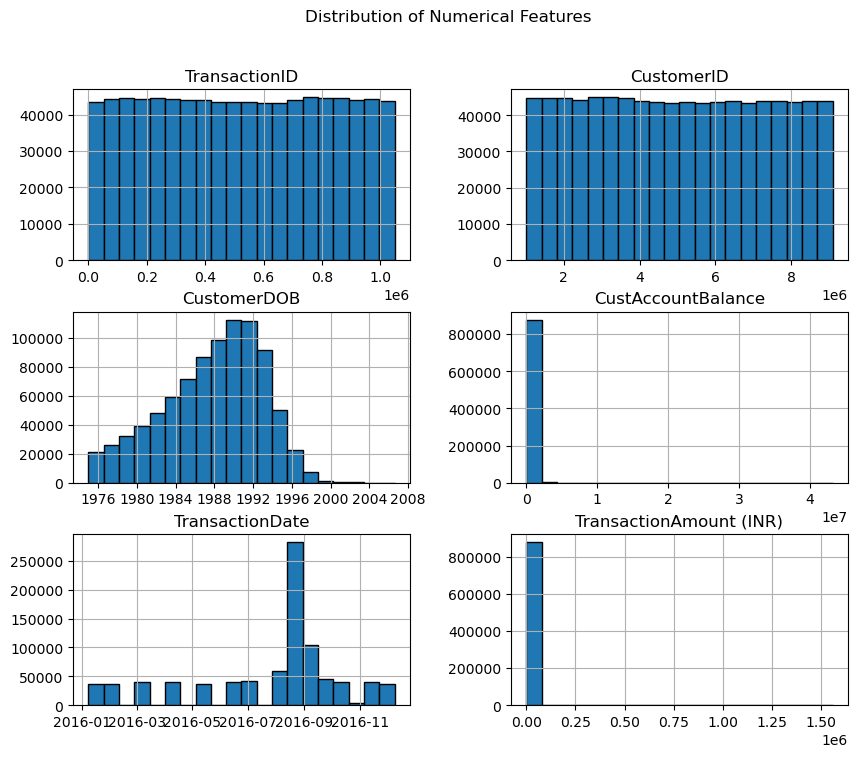

In [87]:
# Histogram of numerical columns
df.hist(bins=20, figsize=(10, 8), edgecolor='black')
plt.suptitle('Distribution of Numerical Features')
plt.show()

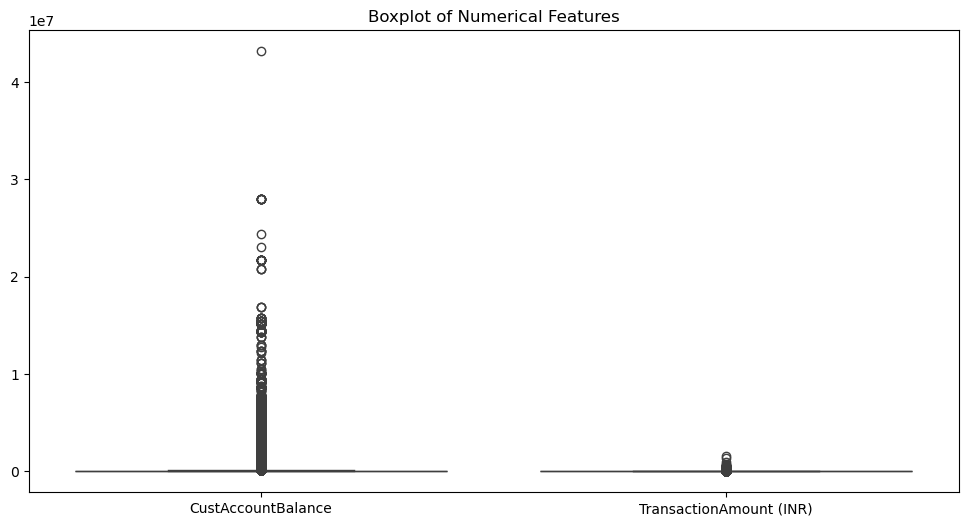

In [88]:
# Boxplot for numerical columns to detect outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['CustomerDOB', 'CustAccountBalance', 'TransactionAmount (INR)']])
plt.title('Boxplot of Numerical Features')
plt.show()

Bar charts of Customer Gender


Text(0.5, 1.0, 'Count of Gender')

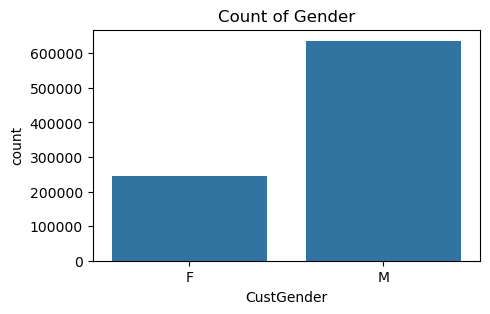

In [89]:
# bar chart of gender column
print('Bar charts of Customer Gender')
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='CustGender')
plt.title('Count of Gender')

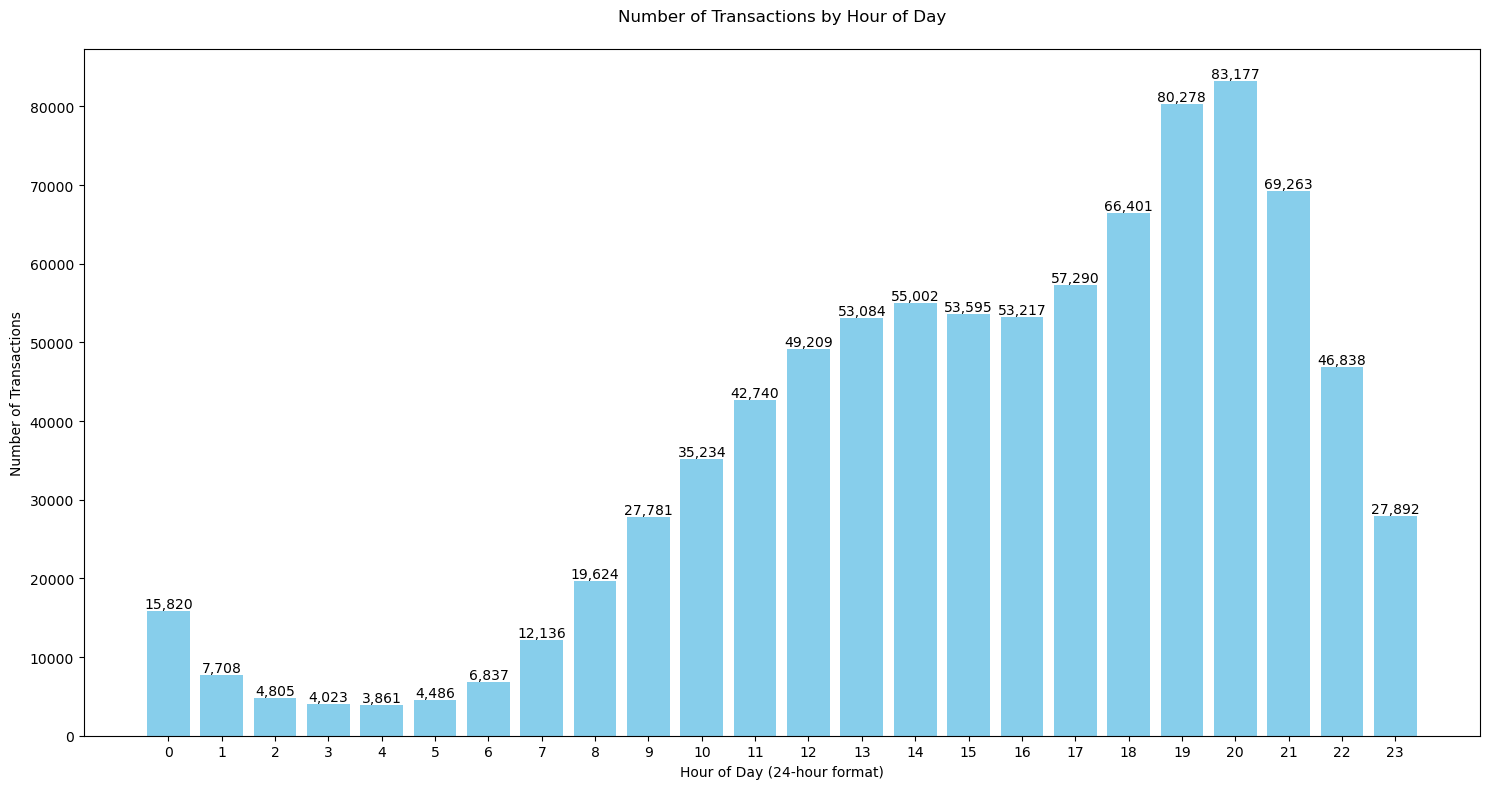

Hourly Transaction Count Summary:
 TransactionTime  TransactionID
               0          15820
               1           7708
               2           4805
               3           4023
               4           3861
               5           4486
               6           6837
               7          12136
               8          19624
               9          27781
              10          35234
              11          42740
              12          49209
              13          53084
              14          55002
              15          53595
              16          53217
              17          57290
              18          66401
              19          80278
              20          83177
              21          69263
              22          46838
              23          27892


In [90]:
# Ensure TransactionTime is in datetime format
df['TransactionTime'] = pd.to_datetime(df['TransactionTime'], format='%H:%M:%S', errors='coerce')

# Group by hour and count transactions
hourly_transaction_counts = df.groupby(df['TransactionTime'].dt.hour)\
    .agg({
        'TransactionID': 'count'  # Count number of transactions
    }).reset_index()

# Create bar plot
plt.figure(figsize=(15, 8))
bars = plt.bar(hourly_transaction_counts['TransactionTime'], 
        hourly_transaction_counts['TransactionID'],
        color='skyblue')

# Customize the plot
plt.title('Number of Transactions by Hour of Day', fontsize=12, pad=20)
plt.xlabel('Hour of Day (24-hour format)')
plt.ylabel('Number of Transactions')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',  # Format as integer with thousands separator
             ha='center', va='bottom')

# Set x-axis ticks to show all 24 hours
plt.xticks(range(0, 24), range(0, 24))

plt.tight_layout()
plt.show()

# Print the hourly distribution
print("\
Hourly Transaction Count Summary:")
print(hourly_transaction_counts.to_string(index=False))

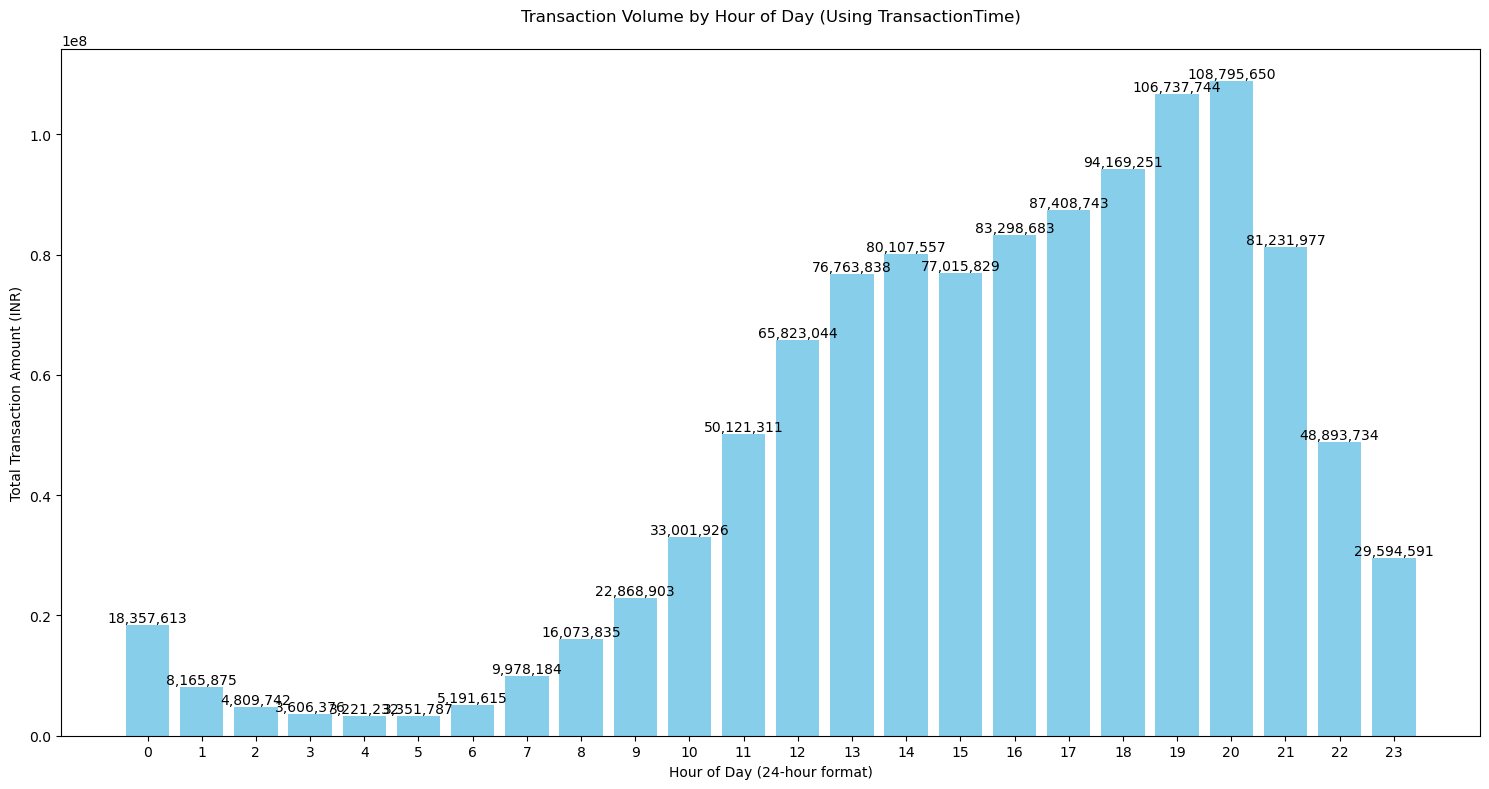

Hourly Transaction Summary (Using TransactionTime):
 TransactionTime  TransactionAmount (INR)
               0              18357613.12
               1               8165875.02
               2               4809741.72
               3               3606376.20
               4               3221231.84
               5               3351787.28
               6               5191614.52
               7               9978184.07
               8              16073834.65
               9              22868902.61
              10              33001926.32
              11              50121310.85
              12              65823044.02
              13              76763837.90
              14              80107557.18
              15              77015829.36
              16              83298682.90
              17              87408743.31
              18              94169251.41
              19             106737743.93
              20             108795649.58
              21        

In [91]:
# Extract hour from TransactionTime and aggregate
# Ensure TransactionTime is in datetime format
df['TransactionTime'] = pd.to_datetime(df['TransactionTime'], format='%H:%M:%S', errors='coerce')

# Group by hour
hourly_transactions_time = df.groupby(df['TransactionTime'].dt.hour)\
    .agg({
        'TransactionAmount (INR)': 'sum'
    }).reset_index()

# Create bar plot
plt.figure(figsize=(15, 8))
bars = plt.bar(hourly_transactions_time['TransactionTime'], 
        hourly_transactions_time['TransactionAmount (INR)'],
        color='skyblue')

# Customize the plot
plt.title('Transaction Volume by Hour of Day (Using TransactionTime)', fontsize=12, pad=20)
plt.xlabel('Hour of Day (24-hour format)')
plt.ylabel('Total Transaction Amount (INR)')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,.0f}',
             ha='center', va='bottom')

# Set x-axis ticks to show all 24 hours
plt.xticks(range(0, 24), range(0, 24))

plt.tight_layout()
plt.show()

# Print the hourly distribution
print("\
Hourly Transaction Summary (Using TransactionTime):")
print(hourly_transactions_time.to_string(index=False))

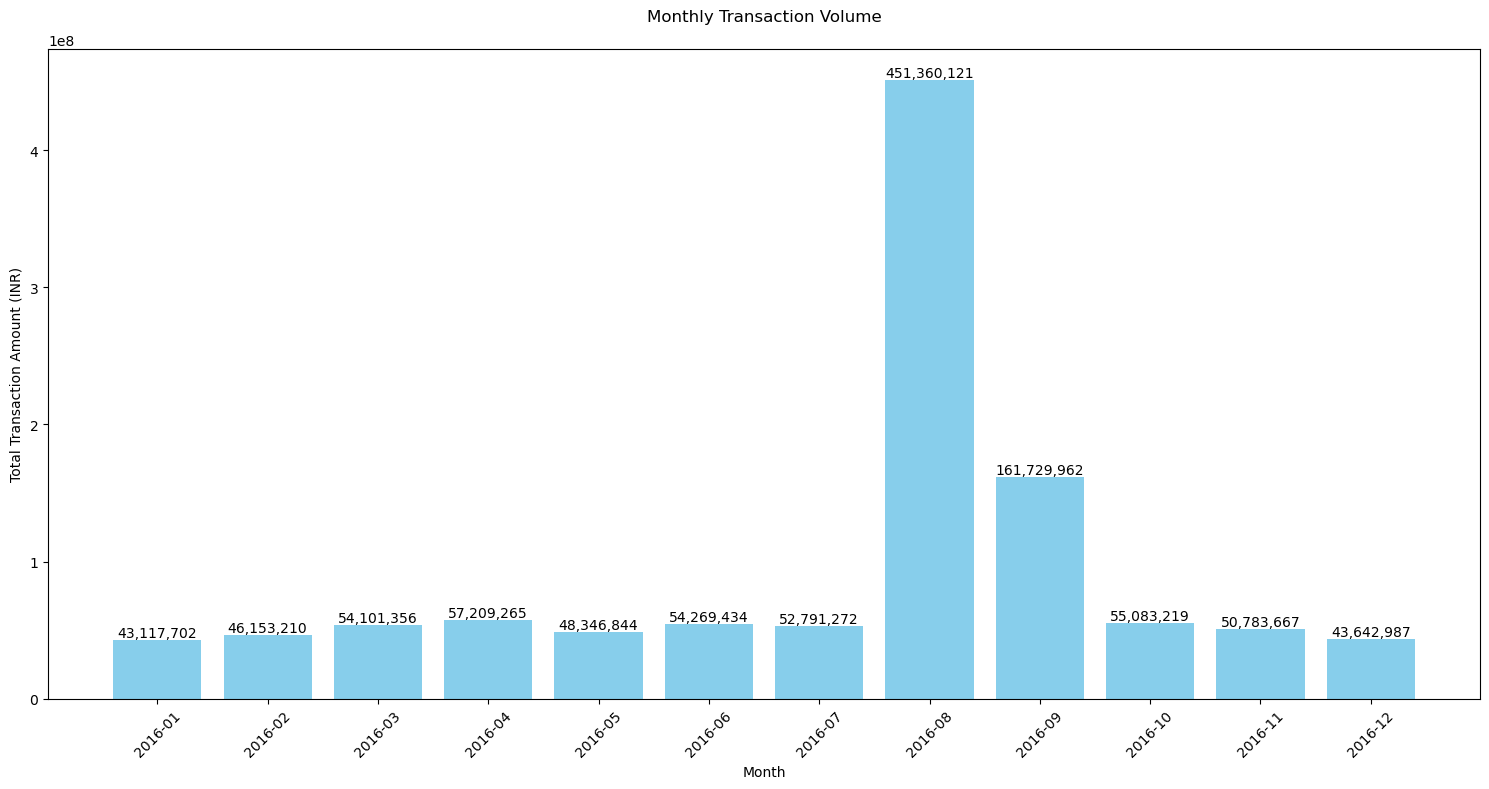

In [92]:
# ensureing the date is in datetime format
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
monthly_transactions = df.groupby(df['TransactionDate'].dt.strftime('%Y-%m'))\
    .agg({
        'TransactionAmount (INR)': 'sum'
    }).reset_index()

# Create bar plot
plt.figure(figsize=(15, 8))
bars = plt.bar(monthly_transactions['TransactionDate'], 
        monthly_transactions['TransactionAmount (INR)'],
        color='skyblue')

# Customize the plot
plt.title('Monthly Transaction Volume', fontsize=12, pad=20)
plt.xlabel('Month')
plt.ylabel('Total Transaction Amount (INR)')
plt.xticks(rotation=45)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,.0f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [93]:
df.to_csv('transaction.csv', index=False)

## Feature Engineering

In [95]:
#first 5 rows of dataset
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,1,5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,1900-01-01 14:32:07,25.0
2,3,4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,1900-01-01 14:27:12,459.0
4,5,9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,1900-01-01 18:11:56,1762.5
6,7,7126560,1992-01-26,F,MUMBAI,973.46,2016-02-08,1900-01-01 17:38:06,566.0
7,8,1220223,1982-01-27,M,MUMBAI,95075.54,2016-02-08,1900-01-01 17:05:37,148.0


In [96]:
# metadata of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 880301 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   TransactionID            880301 non-null  int32         
 1   CustomerID               880301 non-null  int32         
 2   CustomerDOB              880301 non-null  datetime64[ns]
 3   CustGender               880301 non-null  object        
 4   CustLocation             880301 non-null  object        
 5   CustAccountBalance       880301 non-null  float64       
 6   TransactionDate          880301 non-null  datetime64[ns]
 7   TransactionTime          880301 non-null  datetime64[ns]
 8   TransactionAmount (INR)  880301 non-null  float64       
dtypes: datetime64[ns](3), float64(2), int32(2), object(2)
memory usage: 60.4+ MB


In [97]:
# Create a more comprehensive mapping based on the actual data
def create_location_mapping():
    return {
        'Maharashtra': ['MUMBAI', 'PUNE', 'THANE', 'NAVI MUMBAI', 'NASHIK', 'NAGPUR', 'AURANGABAD', 'KALYAN', 
                       'PIMPRI-CHINCHWAD', 'SOLAPUR', 'KOLHAPUR', 'ULHASNAGAR', 'SANGLI'],
        'Delhi-NCR': ['NEW DELHI', 'DELHI', 'GURGAON', 'NOIDA', 'GHAZIABAD', 'FARIDABAD', 'GREATER NOIDA'],
        'Karnataka': ['BANGALORE', 'BENGALURU', 'MYSORE', 'MANGALORE', 'HUBLI', 'BELGAUM', 'GULBARGA'],
        'Tamil Nadu': ['CHENNAI', 'COIMBATORE', 'MADURAI', 'TRICHY', 'SALEM', 'TIRUNELVELI', 'VELLORE'],
        'Telangana': ['HYDERABAD', 'SECUNDERABAD', 'WARANGAL', 'KARIMNAGAR'],
        'West Bengal': ['KOLKATA', 'HOWRAH', 'DURGAPUR', 'SILIGURI', 'ASANSOL'],
        'Gujarat': ['AHMEDABAD', 'SURAT', 'VADODARA', 'RAJKOT', 'GANDHINAGAR', 'BHAVNAGAR'],
        'Rajasthan': ['JAIPUR', 'JODHPUR', 'UDAIPUR', 'KOTA', 'AJMER', 'BIKANER'],
        'Punjab-Chandigarh': ['CHANDIGARH', 'MOHALI', 'LUDHIANA', 'AMRITSAR', 'JALANDHAR', 'PATIALA'],
        'Uttar Pradesh': ['LUCKNOW', 'AGRA', 'KANPUR', 'VARANASI', 'MEERUT', 'ALLAHABAD'],
        'Madhya Pradesh': ['INDORE', 'BHOPAL', 'JABALPUR', 'GWALIOR', 'UJJAIN'],
        'Andhra Pradesh': ['VISAKHAPATNAM', 'VIJAYAWADA', 'GUNTUR', 'TIRUPATI', 'NELLORE'],
        'Kerala': ['KOCHI', 'THIRUVANANTHAPURAM', 'KOZHIKODE', 'THRISSUR', 'ERNAKULAM'],
        'Bihar': ['PATNA', 'GAYA', 'MUZAFFARPUR', 'BHAGALPUR', 'DARBHANGA'],
        'Uttarakhand': ['DEHRADUN', 'HARIDWAR', 'ROORKEE', 'HALDWANI'],
        'Odisha': ['BHUBANESWAR', 'CUTTACK', 'ROURKELA', 'BERHAMPUR'],
        'Assam': ['GUWAHATI', 'DIBRUGARH', 'SILCHAR', 'JORHAT'],
        'Jharkhand': ['RANCHI', 'JAMSHEDPUR', 'DHANBAD', 'BOKARO'],
        'Haryana': ['PANCHKULA', 'KARNAL', 'PANIPAT', 'AMBALA', 'ROHTAK']
    }

def map_location(location):
    if pd.isna(location):
        return 'Unknown'
    
    location = str(location).upper()
    mapping = create_location_mapping()
    
    for region, cities in mapping.items():
        if any(city in location for city in cities):
            return region
            
    return 'Other'



In [98]:
# metadata of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 880301 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   TransactionID            880301 non-null  int32         
 1   CustomerID               880301 non-null  int32         
 2   CustomerDOB              880301 non-null  datetime64[ns]
 3   CustGender               880301 non-null  object        
 4   CustLocation             880301 non-null  object        
 5   CustAccountBalance       880301 non-null  float64       
 6   TransactionDate          880301 non-null  datetime64[ns]
 7   TransactionTime          880301 non-null  datetime64[ns]
 8   TransactionAmount (INR)  880301 non-null  float64       
dtypes: datetime64[ns](3), float64(2), int32(2), object(2)
memory usage: 60.4+ MB


In [99]:
# Calculate age at transaction
df['Customer_Age'] = (df['TransactionDate'].dt.year - df['CustomerDOB'].dt.year)

In [100]:
# 2. Account Balance Category
df['Account_Balance_Category'] = pd.qcut(df['CustAccountBalance'], q=3, labels=['Low', 'Medium', 'High'])


In [101]:

# 3. Transaction Amount Category
df['Transaction_Amount_Category'] = pd.qcut(df['TransactionAmount (INR)'], q=3, labels=['Small', 'Medium', 'Large'])

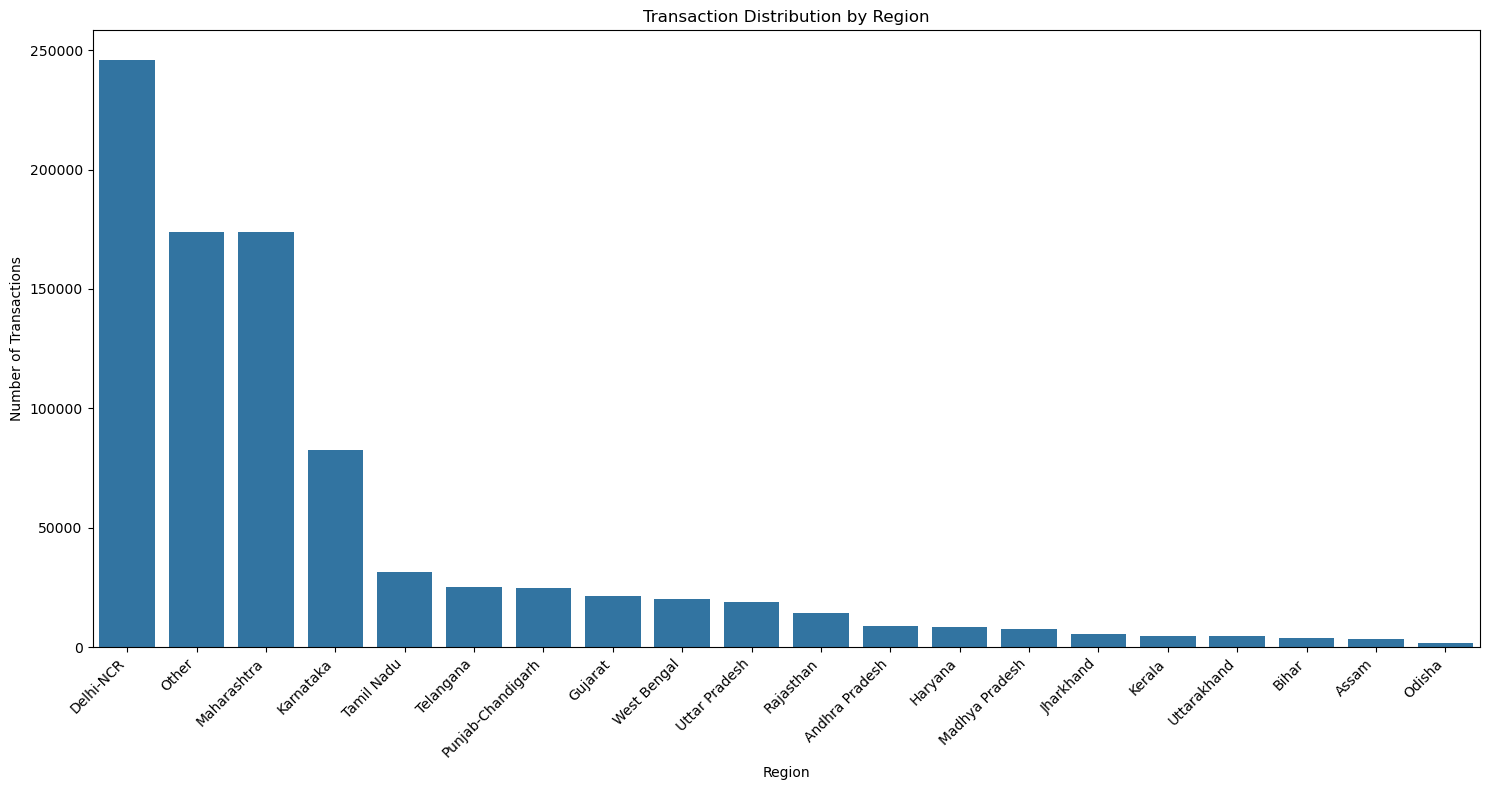

In [102]:

# Apply the new mapping
df['Region'] = df['CustLocation'].apply(map_location)

# Create the visualization
# Get region counts
region_counts = df['Region'].value_counts()

# Create the bar plot
plt.figure(figsize=(15, 8))
sns.barplot(x=region_counts.index, y=region_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title('Transaction Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Number of Transactions')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()


In [103]:
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Customer_Age,Account_Balance_Category,Transaction_Amount_Category,Region
0,1,5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,1900-01-01 14:32:07,25.0,22,Medium,Small,Jharkhand
2,3,4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,1900-01-01 14:27:12,459.0,20,Medium,Medium,Maharashtra
4,5,9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,1900-01-01 18:11:56,1762.5,28,Low,Large,Maharashtra
6,7,7126560,1992-01-26,F,MUMBAI,973.46,2016-02-08,1900-01-01 17:38:06,566.0,24,Low,Medium,Maharashtra
7,8,1220223,1982-01-27,M,MUMBAI,95075.54,2016-02-08,1900-01-01 17:05:37,148.0,34,High,Small,Maharashtra


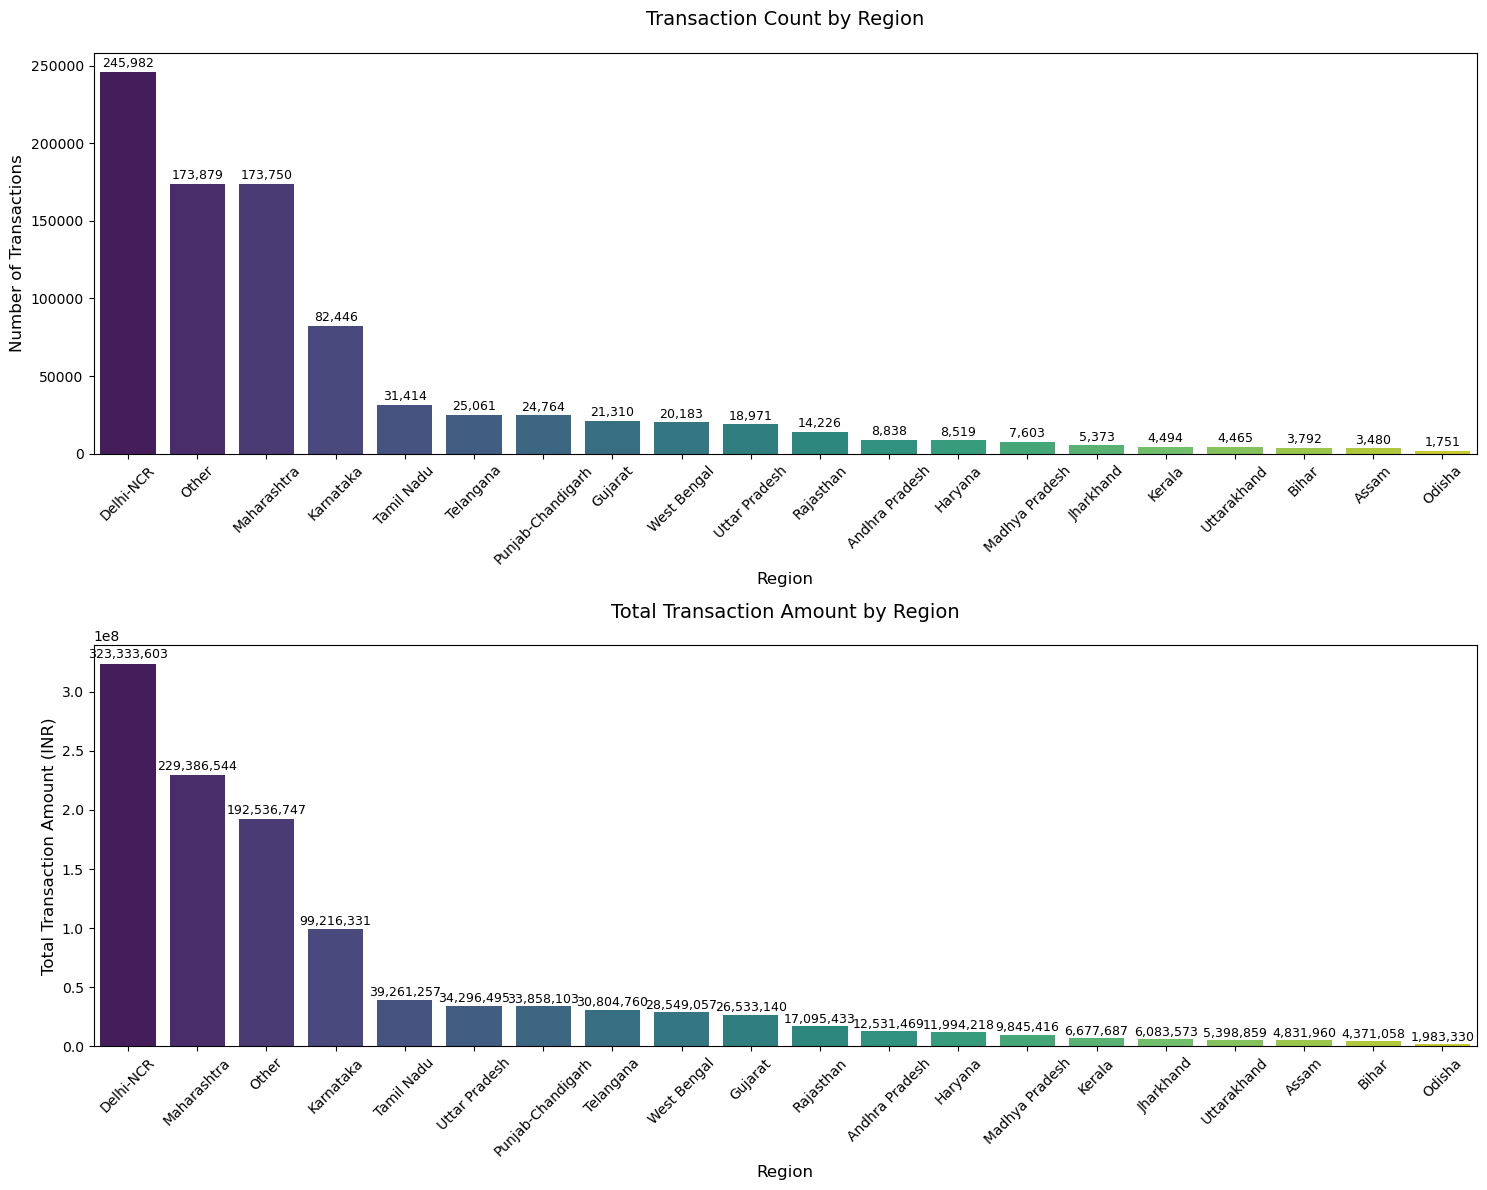


Transaction count by region:
Region
Delhi-NCR            245982
Other                173879
Maharashtra          173750
Karnataka             82446
Tamil Nadu            31414
Telangana             25061
Punjab-Chandigarh     24764
Gujarat               21310
West Bengal           20183
Uttar Pradesh         18971
Rajasthan             14226
Andhra Pradesh         8838
Haryana                8519
Madhya Pradesh         7603
Jharkhand              5373
Kerala                 4494
Uttarakhand            4465
Bihar                  3792
Assam                  3480
Odisha                 1751
Name: count, dtype: int64

Total transaction amount by region (INR):
Region
Delhi-NCR            3.233336e+08
Maharashtra          2.293865e+08
Other                1.925367e+08
Karnataka            9.921633e+07
Tamil Nadu           3.926126e+07
Uttar Pradesh        3.429649e+07
Punjab-Chandigarh    3.385810e+07
Telangana            3.080476e+07
West Bengal          2.854906e+07
Gujarat              

In [104]:


# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: Transaction Count by Region
region_counts = df['Region'].value_counts()
sns.barplot(x=region_counts.index, y=region_counts.values, hue=region_counts.index, palette="viridis", ax=ax1, legend=False)
ax1.set_title('Transaction Count by Region', fontsize=14, pad=20)
ax1.set_xlabel('Region', fontsize=12)
ax1.set_ylabel('Number of Transactions', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Add value labels with formatting
for i, v in enumerate(region_counts.values):
    ax1.text(i, v + 1000, f'{v:,}', ha='center', va='bottom', fontsize=9)

# Plot 2: Total Transaction Amount by Region
region_amounts = df.groupby('Region')['TransactionAmount (INR)'].sum().sort_values(ascending=False)
sns.barplot(x=region_amounts.index, y=region_amounts.values, hue=region_amounts.index, palette="viridis", ax=ax2, legend=False)
ax2.set_title('Total Transaction Amount by Region', fontsize=14, pad=20)
ax2.set_xlabel('Region', fontsize=12)
ax2.set_ylabel('Total Transaction Amount (INR)', fontsize=12)
ax2.tick_params(axis='x', rotation=45)

# Add value labels with formatting
for i, v in enumerate(region_amounts.values):
    ax2.text(i, v + v * 0.01, f'{v:,.0f}', ha='center', va='bottom', fontsize=9, rotation=0)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nTransaction count by region:")
print(region_counts)
print("\nTotal transaction amount by region (INR):")
print(region_amounts)

In [105]:
# Let's also check what locations are in 'Other' category
other_locations = df[df['Region'] == 'Other']['CustLocation'].value_counts().head(20)
print("Top 20 locations in 'Other' category:")
other_locations

Top 20 locations in 'Other' category:


CustLocation
RANGA REDDY          2616
REWARI               2018
ALWAR                1799
NORTH 24 PARGANAS    1721
SONIPAT              1715
BAMBOLIM             1634
ZIRAKPUR             1515
KANGRA               1423
BAREILLY             1406
ALIGARH              1390
RAIPUR               1373
KOTTAYAM             1205
KHARAR               1198
SAHARANPUR           1178
MORADABAD            1176
SAS NAGAR            1167
HOSUR                1155
SHIMLA               1106
BHUBANESHWAR         1080
BURDWAN              1077
Name: count, dtype: int64

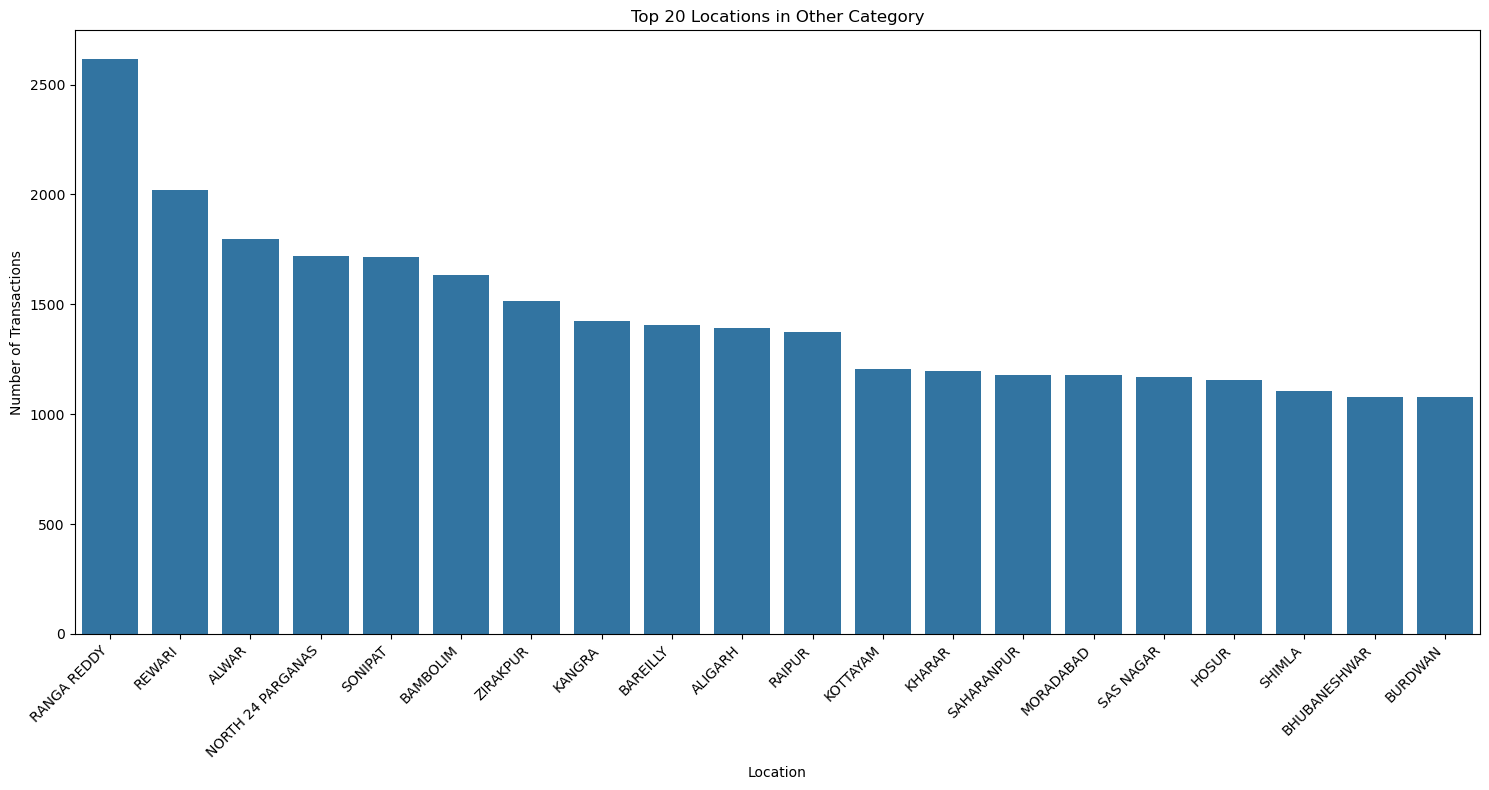

In [106]:
# Get the Other category counts
other_counts = df[df['Region'] == 'Other']['CustLocation'].value_counts().head(20)

# Create the visualization
plt.figure(figsize=(15, 8))
sns.barplot(x=other_counts.index, y=other_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Locations in Other Category')
plt.xlabel('Location')
plt.ylabel('Number of Transactions')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

In [107]:
# creating a copy of the dataset
df1 = df.copy()

# Clustering Analysis

The reasoning behind using 'CustAccountBalance' and 'TransactionAmount (INR)' for clustering is that these variables represent key financial behaviors of customers: their account balance reflects their financial capacity, while transaction amounts indicate their spending patterns. Clustering these variables can help identify distinct customer segments based on financial activity.

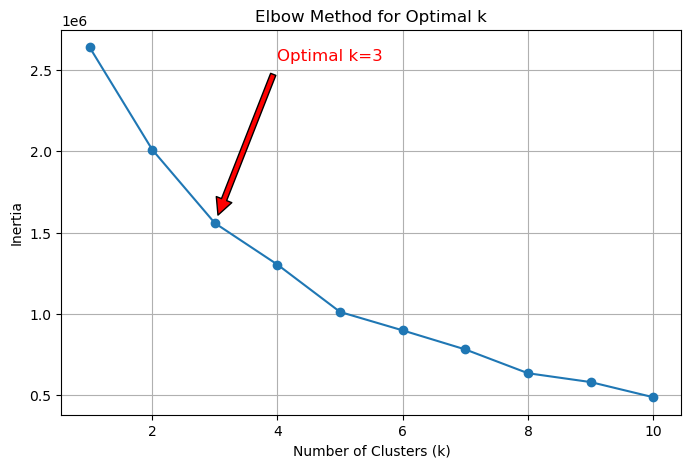

In [110]:

# Preprocessing the data
# Selecting relevant numerical features for clustering
numerical_features = ['CustAccountBalance', 'TransactionAmount (INR)', 'Customer_Age']
df_selected = df[numerical_features]

# Handling missing values (if any)
df_selected = df_selected.dropna()

# Standardizing the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)

# Using the elbow method to find the optimal number of clusters
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)

# Add an arrow at k=3
plt.annotate('Optimal k=3', xy=(3, inertia[2]), xytext=(4, inertia[2] + 1e6),
             arrowprops=dict(facecolor='red', shrink=0.05), fontsize=12, color='red')


plt.show()


The arrow in the plot points to where the "elbow" occurs in the curve, showing where adding more clusters starts to have diminishing returns in terms of reducing inertia. After this point (k=3), the reduction in inertia becomes less significant, suggesting that three clusters provide an optimal balance between model complexity and cluster quality.

## Optimization

- Scaling: Uses RobustScaler to scale the features, making it more robust to outliers.
- Clustering: Uses KMeans with n_init=10 to run the algorithm with 10 different initializations, potentially improving the clustering results.
- Evaluation: Calculates both silhouette scores and inertia for different values of k (number of clusters).

In [114]:
# Preprocessing the data
# Selecting relevant numerical features for clustering
numerical_features = ['CustAccountBalance', 'TransactionAmount (INR)', 'Customer_Age']
df_selected = df[numerical_features]

# Handling missing values (if any)
df_selected = df_selected.dropna()

# Take a smaller random sample
np.random.seed(42)
df_sample = df_selected.sample(n=1000)

# Select features for clustering
features = ['CustAccountBalance', 'TransactionAmount (INR)', 'Customer_Age']
X = df_sample[features]

# Scale the features using RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Calculate metrics for different k values
k_range = range(2, 6)
silhouette_scores = []
inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    inertias.append(kmeans.inertia_)

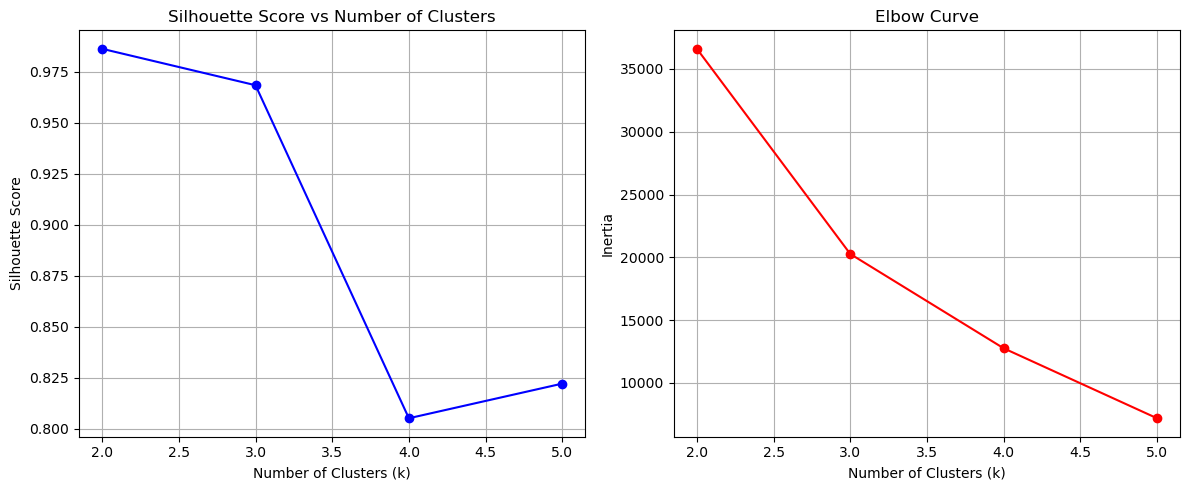

Optimal number of clusters based on silhouette score: 2
Best silhouette score: 0.9862


In [115]:

# Plot results
plt.figure(figsize=(12, 5))

# Silhouette score plot
plt.subplot(1, 2, 1)
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True)

# Elbow curve
plt.subplot(1, 2, 2)
plt.plot(k_range, inertias, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.grid(True)

plt.tight_layout()
plt.show()

# Find and print optimal k
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")
print(f"Best silhouette score: {max(silhouette_scores):.4f}")

# Perform clustering with optimal k
optimal_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_sample['Cluster'] = optimal_kmeans.fit_predict(X_scaled)



In [116]:

# Define features for clustering
features = ['CustAccountBalance', 'TransactionAmount (INR)', 'Customer_Age']
X = df[features].copy()

# Handle missing values
X = X.fillna(X.mean())

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Perform K-means clustering with deterministic settings
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10, max_iter=300)
df['Cluster'] = kmeans.fit_predict(X_scaled)


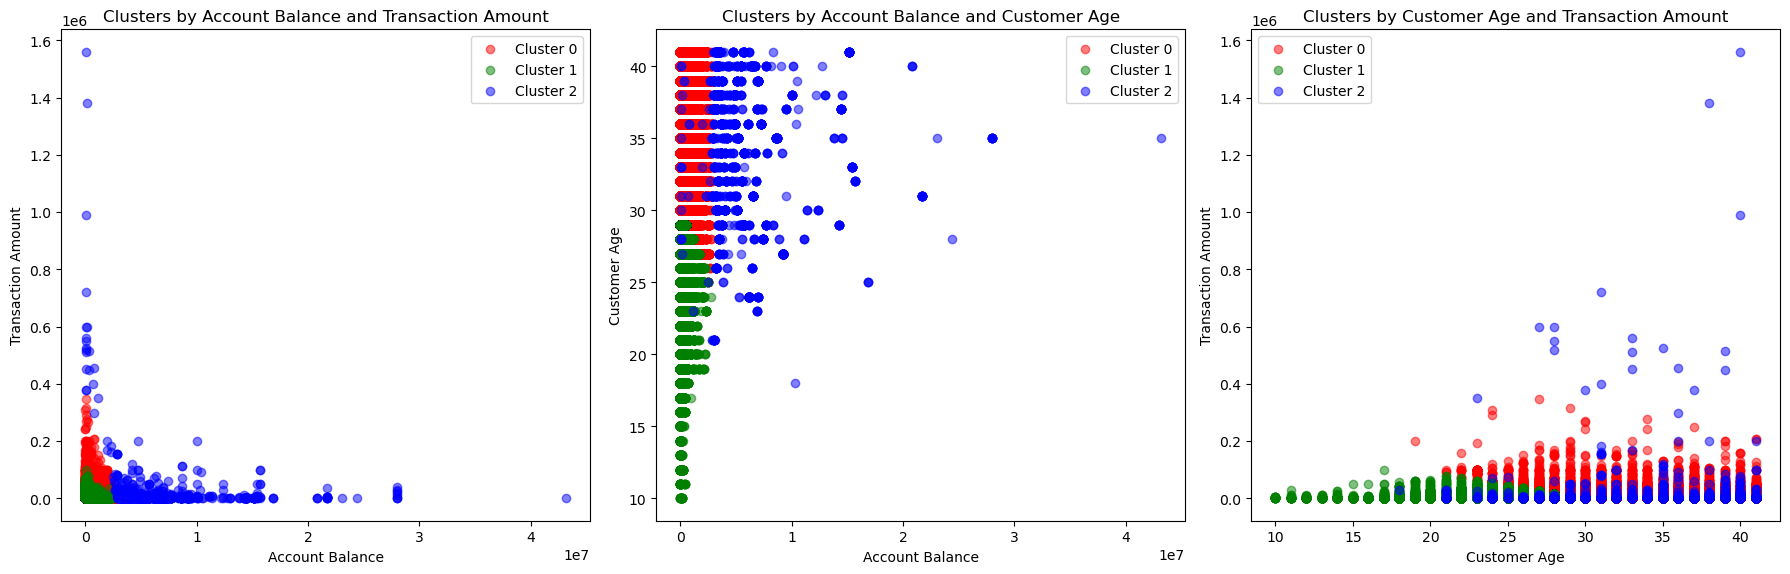

In [117]:
# Define colors for clusters
colors = ['red', 'green', 'blue']

# Create the visualization
plt.figure(figsize=(18, 6))

# Plot 1: Account Balance vs Transaction Amount
plt.subplot(1, 3, 1)
for i in range(3):
    mask = df['Cluster'] == i
    plt.scatter(df[mask]['CustAccountBalance'], 
               df[mask]['TransactionAmount (INR)'],
               c=colors[i],
               label=f'Cluster {i}',
               alpha=0.5)
plt.xlabel('Account Balance')
plt.ylabel('Transaction Amount')
plt.title('Clusters by Account Balance and Transaction Amount')
plt.legend()

# Plot 2: Account Balance vs Customer Age
plt.subplot(1, 3, 2)
for i in range(3):
    mask = df['Cluster'] == i
    plt.scatter(df[mask]['CustAccountBalance'], 
               df[mask]['Customer_Age'],
               c=colors[i],
               label=f'Cluster {i}',
               alpha=0.5)
plt.xlabel('Account Balance')
plt.ylabel('Customer Age')
plt.title('Clusters by Account Balance and Customer Age')
plt.legend()

# Plot 3: Customer Age vs Transaction Amount
plt.subplot(1, 3, 3)
for i in range(3):
    mask = df['Cluster'] == i
    plt.scatter(df[mask]['Customer_Age'], 
               df[mask]['TransactionAmount (INR)'],
               c=colors[i],
               label=f'Cluster {i}',
               alpha=0.5)
plt.xlabel('Customer Age')
plt.ylabel('Transaction Amount')
plt.title('Clusters by Customer Age and Transaction Amount')
plt.legend()

plt.tight_layout()
plt.show()


In [118]:

# Generate summary statistics
summary = df.groupby('Cluster')[features].agg(['mean', 'count'])

# Rename columns for better readability
summary.columns = ['Balance_Mean', 'Balance_Count', 
                  'Transaction_Mean', 'Transaction_Count',
                  'Age_Mean', 'Age_Count']

# Round numerical values
summary = summary.round(2)

# Add percentage of total for each cluster
total_records = len(df)
summary['Cluster_Size_Percentage'] = (summary['Balance_Count'] / total_records * 100).round(2)

print("\
Cluster Summary Statistics:")
summary

Cluster Summary Statistics:


,Balance_Mean,Balance_Count,Transaction_Mean,Transaction_Count,Age_Mean,Age_Count,Cluster_Size_Percentage
Cluster,,,,,,,
0,104089.48,349573,1859.68,349573,33.96,349573,39.71
1,39805.15,528876,842.43,528876,25.23,528876,60.08
2,5598619.10,1852,12393.25,1852,34.21,1852,0.21


Cluster 0 represents customers with moderate balances and higher transaction amounts, likely middle-aged individuals with average spending behavior.
Cluster 1 comprises younger customers with the lowest balances and transaction amounts, likely representing entry-level or lower-income customers.
Cluster 2 includes a small group of wealthy customers with very high balances and transaction activity, mostly older individuals.

## Marketing Strategy for Each Cluster

Cluster 0: Moderate Balances and Spending (Middle-Aged Customers)
Position tailored financial products such as mid-range investment plans or family-oriented savings accounts to align with their moderate balances and spending. Highlight value-added services like budgeting tools or rewards programs to encourage loyalty. Emphasize convenience and personalized advice to retain these customers who likely value stability and practicality.

Cluster 1: Low Balances and Spending (Younger Customers)
Focus on entry-level products like starter savings accounts, low-fee credit cards, or financial education programs to engage younger, cost-conscious individuals. Use digital-first marketing strategies like social media campaigns and mobile app offers to connect with their tech-savvy habits. Promote gamified saving tools or rewards for small milestones to build loyalty and long-term relationships.

Cluster 2: High Balances and Spending (Wealthy, Older Customers)
Offer premium, personalized services such as wealth management, exclusive credit cards, and tailored investment portfolios to meet their high-value needs. Use relationship managers to deliver white-glove service and create a sense of exclusivity. Highlight benefits like priority support, access to exclusive events, and bespoke financial advice to solidify trust and retain their business.

# Classification

In [123]:
# metadata of data
df1.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 880301 entries, 0 to 1048566
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   TransactionID                880301 non-null  int32         
 1   CustomerID                   880301 non-null  int32         
 2   CustomerDOB                  880301 non-null  datetime64[ns]
 3   CustGender                   880301 non-null  object        
 4   CustLocation                 880301 non-null  object        
 5   CustAccountBalance           880301 non-null  float64       
 6   TransactionDate              880301 non-null  datetime64[ns]
 7   TransactionTime              880301 non-null  datetime64[ns]
 8   TransactionAmount (INR)      880301 non-null  float64       
 9   Customer_Age                 880301 non-null  int32         
 10  Account_Balance_Category     880301 non-null  category      
 11  Transaction_Amount_Category  8

In [124]:
# Convert 'TransactionDate' to string
df1['TransactionDate'] = df1['TransactionDate'].astype(str)

# Convert 'TransactionTime' to string
df1['TransactionTime'] = df1['TransactionTime'].astype(str) 

In [125]:
# Feature engineering
# Convert TransactionDate and TransactionTime to datetime
df1['TransactionDateTime'] = pd.to_datetime(df1['TransactionDate'] + ' ' + df1['TransactionTime'].str.split(' ').str[-1])

# Create new features
df1['Transaction_to_Balance_Ratio'] = df1['TransactionAmount (INR)'] / df1['CustAccountBalance']
df1['Hour'] = df1['TransactionDateTime'].dt.hour
df1['DayOfWeek'] = df1['TransactionDateTime'].dt.dayofweek

In [126]:
# Select features for the model
features = ['TransactionAmount (INR)',  'CustAccountBalance', 'Transaction_to_Balance_Ratio', 'Hour', 'DayOfWeek', 'Customer_Age']

# Prepare feature matrix X
X = df1[features].copy()

In [127]:

# Handle infinite values and missing values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean())

# Create target variable y (using Isolation Forest for initial fraud labels)
iso_forest = IsolationForest(contamination=0.1, random_state=42)
y = pd.Series(iso_forest.fit_predict(X)).map({1: 0, -1: 1})

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Use RobustScaler instead of StandardScaler
robust_scaler = RobustScaler()
X_train_scaled = robust_scaler.fit_transform(X_train)
X_test_scaled = robust_scaler.transform(X_test)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

In [ ]:
# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


In [ ]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix with improved styling
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix', fontsize=14, pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Add labels for fraud and non-fraud
plt.gca().set_xticklabels(['Non-Fraud', 'Fraud'])
plt.gca().set_yticklabels(['Non-Fraud', 'Fraud'])
plt.show()

In [ ]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance with improved styling
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Fraud Detection', fontsize=14, pad=20)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

In [ ]:

# Calculate and print probabilities distribution
fraud_probs = rf_model.predict_proba(X_test_scaled)[:, 1]

# Plot probability distribution with improved styling and legend
plt.figure(figsize=(12, 8))
plt.hist(fraud_probs[y_test == 0], bins=50, alpha=0.5, color='blue', label='Non-Fraudulent')
plt.hist(fraud_probs[y_test == 1], bins=50, alpha=0.5, color='red', label='Fraudulent')
plt.title('Distribution of Fraud Probabilities by Class', fontsize=14, pad=20)
plt.xlabel('Probability of Fraud', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
# Print feature importance
print("\
Feature Importance Ranking:")
print(feature_importance.to_string(index=False))